# A Neural Network approach

Import librarys and functions needed for this problem

In [21]:
# Librarys imported
import pandas as pd
import numpy as np

import torch
import torchvision
import torch.nn as nn

from matplotlib import pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

import time

In [22]:
# Import helper functions from functions.py
import sys
import importlib
sys.path.append('..')
import functions
# reload file to check if there were any updates to file
importlib.reload(functions)
from functions import *

## Load data and augment data
1. load Dataset
2. clean data
3. create train & test data

In [23]:
Path = "C:/Users/Billy/Documents/University/Year 4/Comp/CW2/palmerpenguins_extended.csv"
df_penguin = get_data(Path)
df_penguin = augment_data(df_penguin);
X_train, X_test, y_train, y_test = datasplit_train_test(df_penguin)

c:\Users\Billy\Documents\University\Year 4\Comp\CW2\CW2 Code\COURSEWORK-2-DATA-SCIENCE-PROJECT\py\Q2_folder\..\functions.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataframe_name.island = dataframe_name.island.replace({'Biscoe':0,'Dream':1,'Torgensen':2})
c:\Users\Billy\Documents\University\Year 4\Comp\CW2\CW2 Code\COURSEWORK-2-DATA-SCIENCE-PROJECT\py\Q2_folder\..\functions.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataframe_name.species = dataframe_name.species.replace({'Adelie':0,'Chinstrap':1,'Gentoo':2})
c

## Make data class for nerual network

In [ ]:
#Reference: https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html
# Create a class for data as it is needed for pytoch data to train and test the neural network
class Mydata(torch.utils.data.Dataset):
    def __init__(self, X_train, y_train):
        super().__init__()
        # Add the features (X) and the target (y)
        self.X = torch.from_numpy(X_train.values).type(torch.FloatTensor)
        self.y = torch.from_numpy(y_train.values.flatten()).type(torch.LongTensor)
        self.len = self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.len

In [25]:
# Using the class and the traing/test data create datasets for neural network

# Create training data 
data_train = Mydata(X_train, y_train)
# create training data loader at batch size 32
train_loader = torch.utils.data.DataLoader(dataset=data_train, batch_size=32)
# Create test data 
data_test = Mydata(X_test,y_test)
# Create test data loader with batch size 32
test_loader = torch.utils.data.DataLoader(dataset=data_test, batch_size=32)

## Create Neural Network

In [ ]:
# Parameters for layers within the neural network
INPUT_NUM = 9 # Starting number of features
HIDDEN_NUM = 20 # number of nodes within hidden layer
OUTPUT_NUM = 3 # Number of classes to choose between at the end

class MultiClassNet(nn.Module):
    def __init__(self, INPUT_NUM, HIDDEN_NUM, OUTPUT_NUM):
        super().__init__()
        self.lin1 = nn.Linear(INPUT_NUM, HIDDEN_NUM)
        self.lin2 = nn.Linear(HIDDEN_NUM, OUTPUT_NUM)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.lin1(x)
        x = torch.sigmoid(x)
        x = self.lin2(x)
        x = self.log_softmax(x)
        return x

Training model

In [ ]:
# Reference: ACT_Course_Convolutional_Neural_Network.ipynb Portsmouth uni Advanced Computational Techniques notebook
# Measuing time it takes to train neural network for comparison
neuralTime0 = time.time()
# Create neual network
model = MultiClassNet(INPUT_NUM=INPUT_NUM, HIDDEN_NUM=HIDDEN_NUM, OUTPUT_NUM=OUTPUT_NUM)

# Choose loss function
criterion = nn.CrossEntropyLoss()
# Choose learning rate
lr = 0.1
# create optimizer for training model
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# Select number of epochs to train model
NUM_EPOCHS = 500
# Create a list to see the loss at each epoch when training model
losses = []
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0.0
    for x, y in train_loader:

        # Initialize gradients
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(x)

        # Calculate loss
        loss = criterion(y_pred, y)

        # Backpropagation
        loss.backward()

        # Update parameters
        optimizer.step()

        epoch_loss += loss.item()

    # Find loss at current epoch
    average_loss = epoch_loss / len(train_loader)
    losses.append(average_loss)
    
neuralTime1 = time.time()
neuralTime = neuralTime1 - neuralTime0

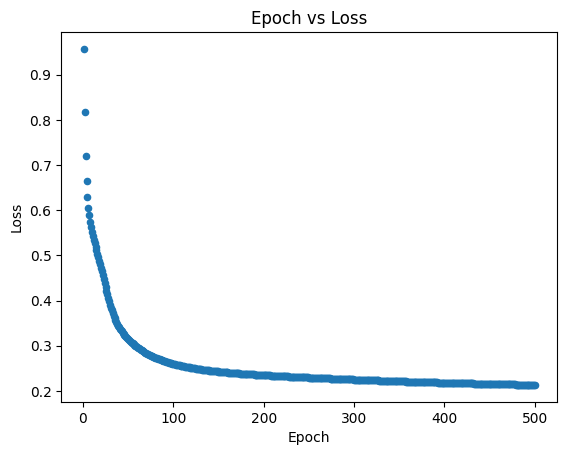

In [ ]:
# Plot epoch against loss when training model
epochList = np.linspace(1,500,500)
plt.scatter(epochList,losses,s=20)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss');

# From the graph you can see that it starts to level off 
# This meaning that adding more epochs when training will get deminishing returns


From the graph you can see that the reduction in loss starts to decrease the more you increase the number of epochs. <br>
This shows that increasing the epoch number further would not give enough of an increase in accuracy compared to how long it would take to train it.

In [29]:
# Save the trained neural network to be able to test it later
PATH = './nn.pth' #change maybe
torch.save(model.state_dict(), PATH)

## Testing accuracy of Neural Network

In [ ]:
# Reference: ACT_Course_Convolutional_Neural_Network.ipynb Portsmouth uni Advanced Computational Techniques notebook
# prepare to count predictions for each class
classes = [0,1,2]
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
# list of accuacy for each class to plot against non neural network approach
neural_class = []

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        features, labels = data
        outputs = model(features)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    neural_class.append(accuracy)
    print(f'Accuracy for class: {classname:.0f} is {accuracy:.1f} %')

Accuracy for class: 0 is 88.3 %
Accuracy for class: 1 is 72.4 %
Accuracy for class: 2 is 96.5 %


In [ ]:
# Reference: ACT_Course_Convolutional_Neural_Network.ipynb Portsmouth uni Advanced Computational Techniques notebook
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        features, labels = data
        # calculate outputs by running features through the network
        outputs = model(features)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of model on whole test set: {100 * correct // total} %')

Accuracy of model on whole test set: 88 %


## Comparing neural network and non neural network approach

In [32]:
# Getting the accuracy for each class using the Decision tree from Q1
DecisionTree_reduced = DecisionTreeClassifier(max_depth=9)

# Measure the time it takes for thw decision tree to train 
# Take time at start of training
TreeTime0 = time.time()
DecisionTree_reduced = DecisionTree_reduced.fit(X_train,y_train)
# Measure time at end of training
TreeTime1 = time.time()
TreeTime = TreeTime1 - TreeTime0 # Using the two times find time taken to train model

test_accuracy = DecisionTree_reduced.score(X_test, y_test)

# Additional list for accuracy of each class
non_class = []

for i in range(3):
    Xtest_class = X_test[y_test['species'] == i]
    data_len = len(Xtest_class)
    ytest_class = pd.DataFrame([i]*data_len,columns=y_test.columns)
    reducedAccuracy = DecisionTree_reduced.score(Xtest_class,ytest_class)
    # Add accuracy to list
    non_class.append(reducedAccuracy*100)

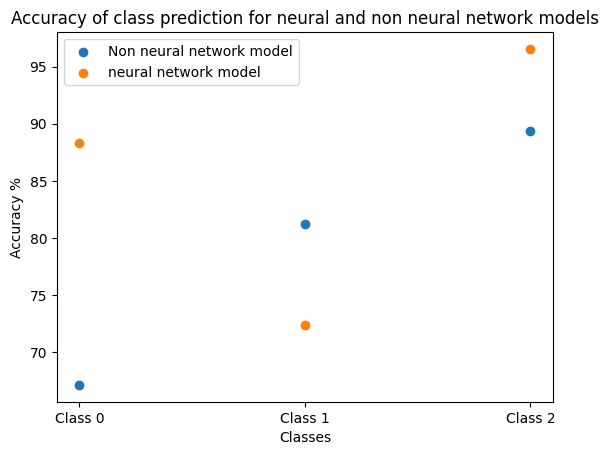

In [33]:
# Plot the accuacy for the 3 classes from both models
plt.Figure()
plt.scatter(classes,non_class,label="Non neural network model")
plt.scatter(classes,neural_class,label="neural network model")

# Change x axis to the 3 classes that are being predicted
plt.xticks([0,1,2],['Class 0','Class 1', 'Class 2'])
plt.xlabel('Classes')
plt.ylabel('Accuracy %')
plt.title('Accuracy of class prediction for neural and non neural network models')
plt.legend()

From comparing the 2 models you can see that the neural network has an average accuaracy higher than the decision tree.<br>
However you also have to consider the time it takes to train both models

### Compare the time it took to train the 2 models

Neural Network model: 28.68 seconds
Decision tree model: 0.02 seconds


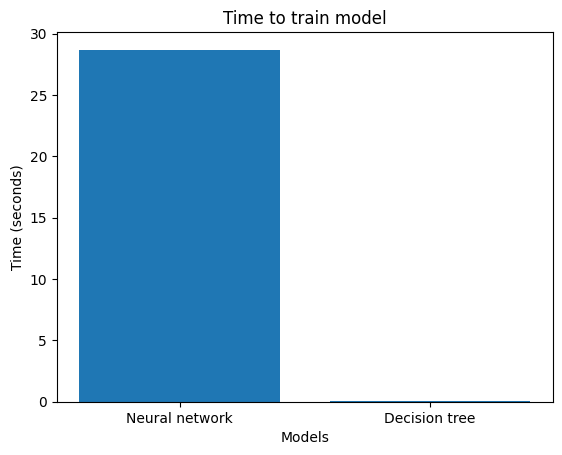

In [34]:
# using the time measured previously to plot them on the same graph
# You can see that there is a big different between them.

# Plot both times
plt.bar(['Neural network','Decision tree'],[neuralTime,TreeTime])
plt.xlabel('Models')
plt.ylabel('Time (seconds)')
plt.title('Time to train model');
# Print times for both models for easier comparison
print(f"Neural Network model: {neuralTime:.2f} seconds")
print(f"Decision tree model: {TreeTime:.2f} seconds")